# Analise de Resultados 

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Leitura e renomeação de colunas se necessário
df = pd.read_csv('pcap_results.csv')

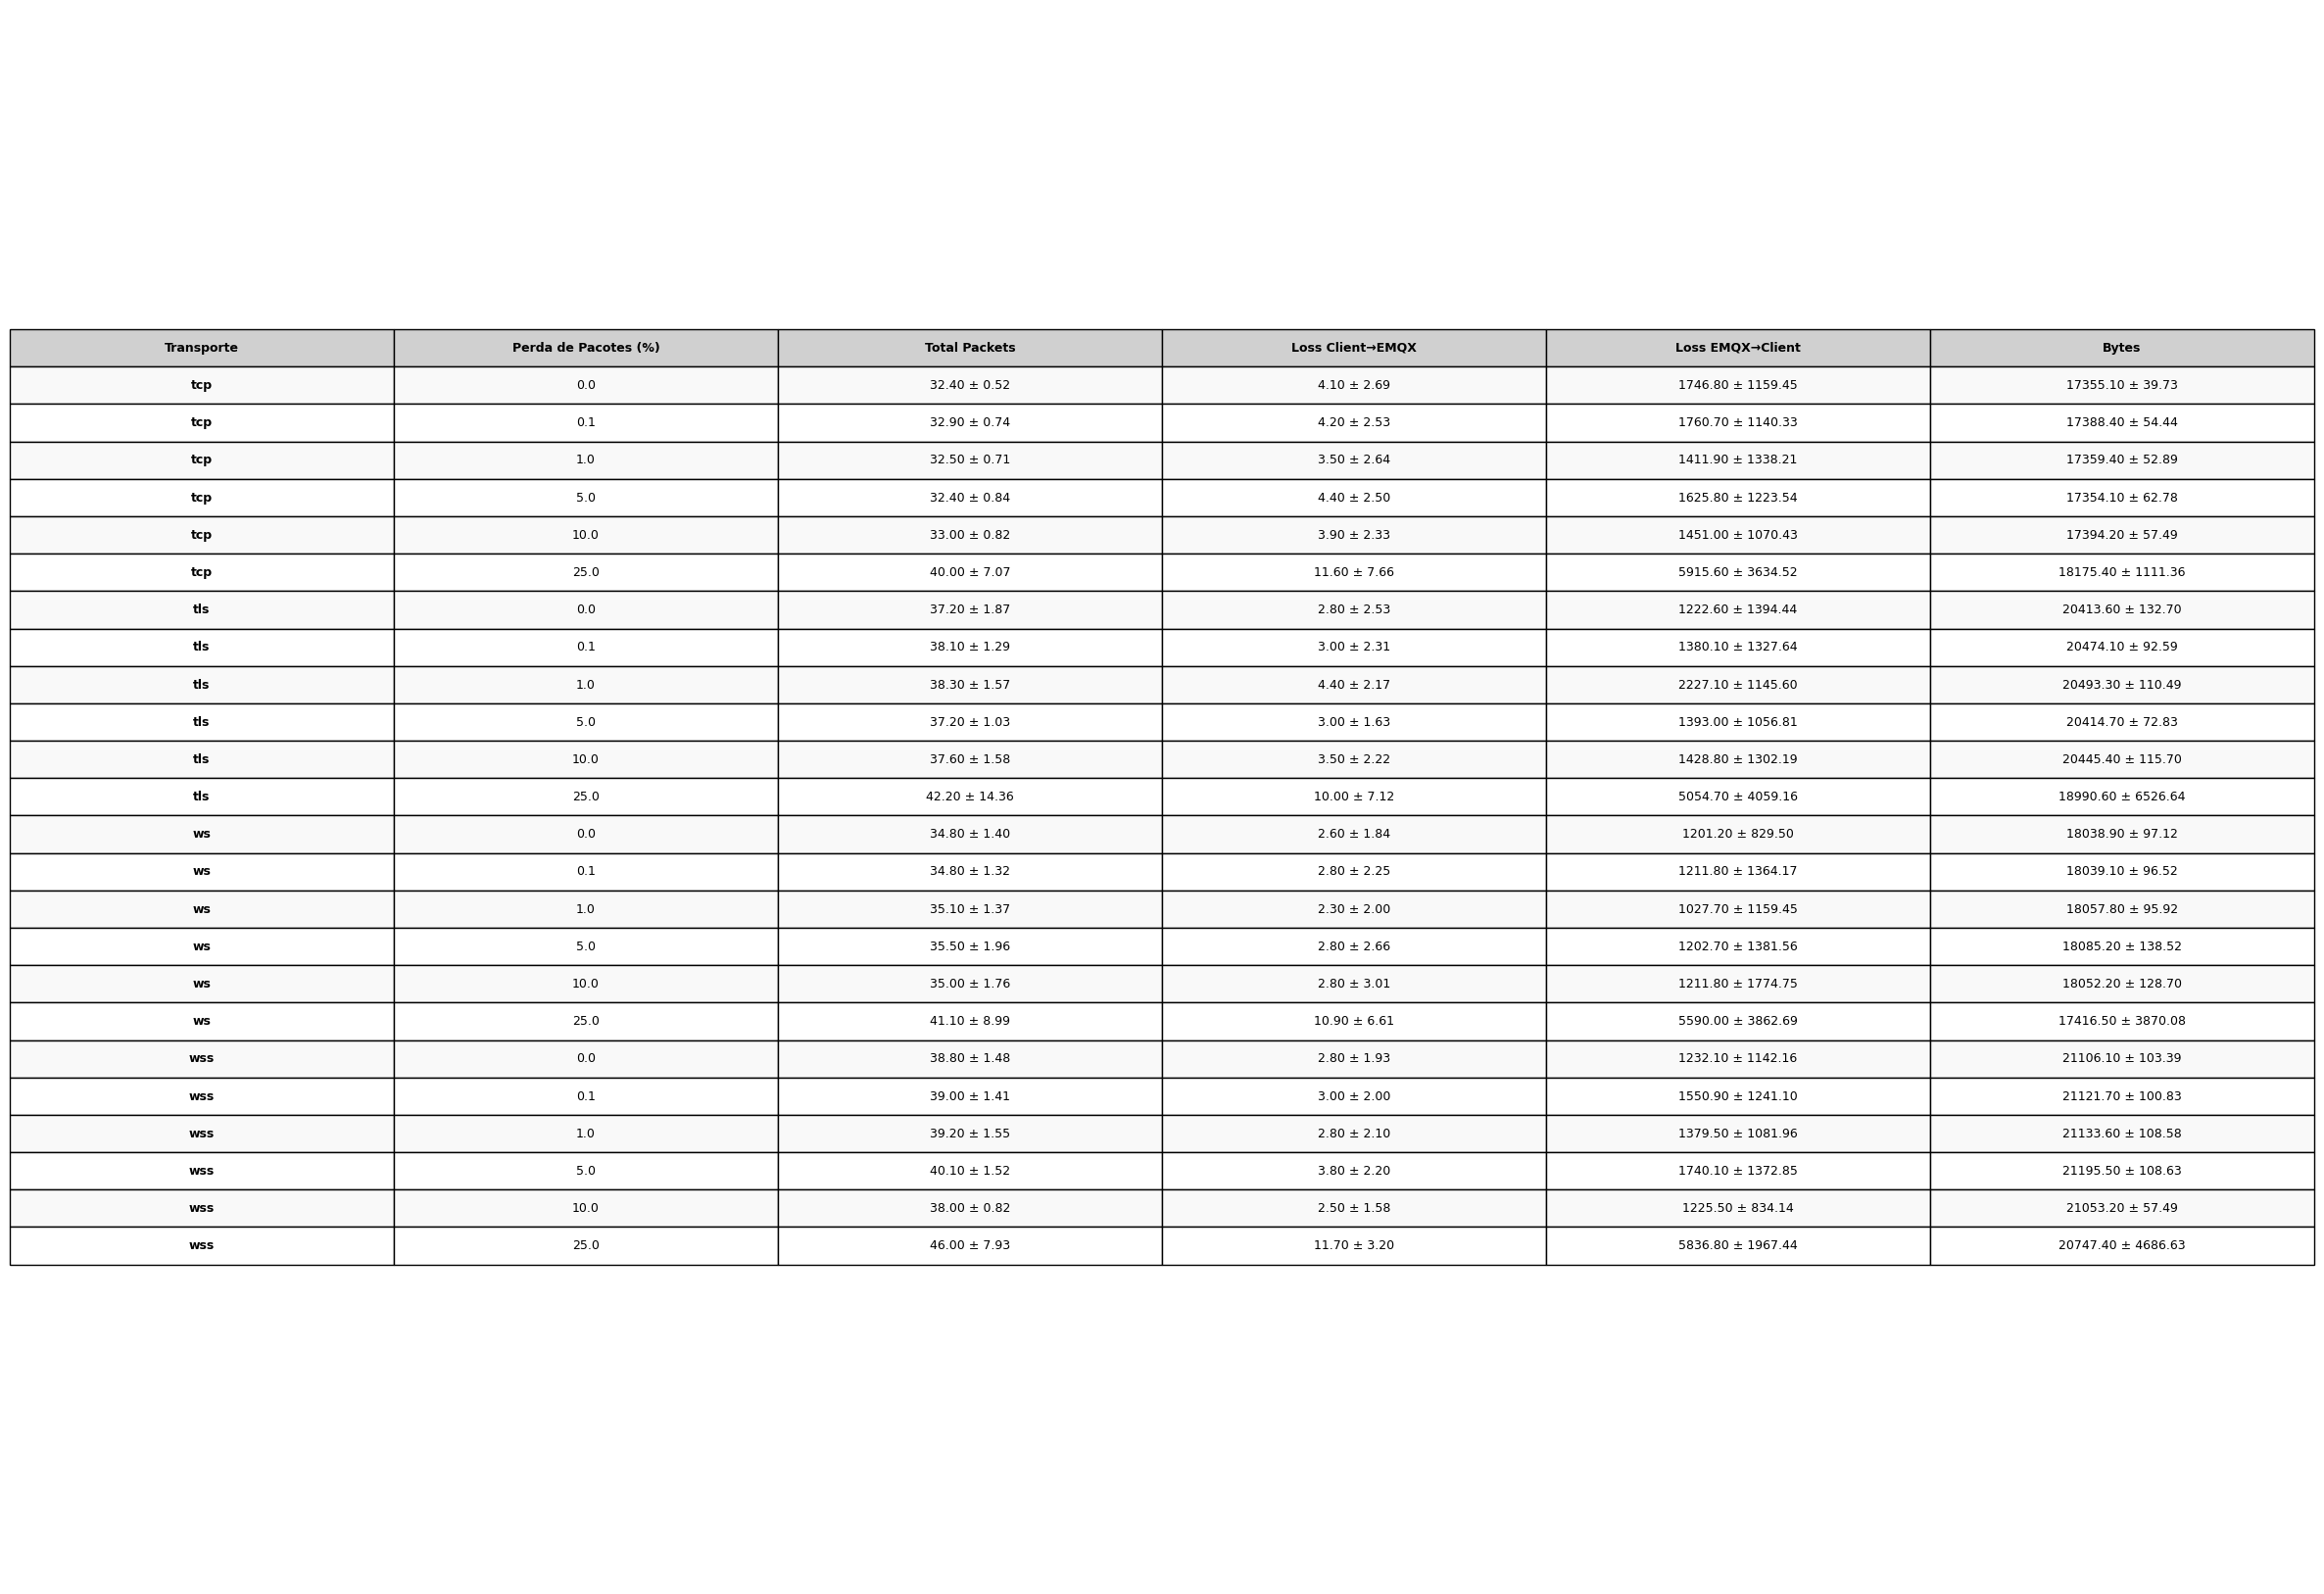

In [18]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

grouped = df.groupby(['transport', 'loss']).agg({
    'total_packets': ['mean', 'std'],
    'total_bytes': ['mean', 'std'],
    'error_packets': ['mean', 'std'],
    'error_bytes': ['mean', 'std'],
}).reset_index()

grouped.columns = ['transport', 'loss',
                   'total_packets_mean', 'total_packets_std',
                   'total_bytes_mean', 'total_bytes_std',
                   'loss_client_emqx_mean', 'loss_client_emqx_std',
                   'loss_emqx_client_mean', 'loss_emqx_client_std']

formatted_rows = []
for _, row in grouped.iterrows():
    formatted_rows.append({
        'loss_val': float(row['loss']),  # <-- aqui!
        'Transporte': row['transport'],
        'Perda de Pacotes (%)': f"{row['loss']:.1f}",
        'Total Packets': f"{row['total_packets_mean']:.2f} ± {row['total_packets_std']:.2f}",
        'Loss Client→EMQX': f"{row['loss_client_emqx_mean']:.2f} ± {row['loss_client_emqx_std']:.2f}",
        'Loss EMQX→Client': f"{row['loss_emqx_client_mean']:.2f} ± {row['loss_emqx_client_std']:.2f}",
        'Bytes': f"{row['total_bytes_mean']:.2f} ± {row['total_bytes_std']:.2f}",
    })

# 7. Ordena pela perda real e remove a coluna auxiliar
formatted_table = pd.DataFrame(formatted_rows).sort_values(by='loss_val').drop(columns='loss_val').reset_index(drop=True)

# Função para salvar tabela como imagem
def save_summary_table(df, filename='tabela_wss_summary.png'):
    n_rows, n_cols = df.shape
    fig_height = n_rows * 0.6 + 2
    fig, ax = plt.subplots(figsize=(20, fig_height))
    ax.axis('off')

    row_colors = ['#f9f9f9' if i % 2 == 0 else 'white' for i in range(n_rows)]
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(1)
        if row == 0:
            cell.set_text_props(weight='bold', color='black')
            cell.set_facecolor('#d0d0d0')
        elif row > 0:
            cell.set_facecolor(row_colors[row - 1])
            if col == 0:
                cell.set_text_props(weight='bold')

    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

ordem_transporte = {
    'tcp': 1,
    'tls': 2,
    'ws': 3,
    'wss': 4
}
formatted_table['transport_order'] = formatted_table['Transporte'].map(ordem_transporte).fillna(99)


formatted_table['loss_val'] = formatted_table['Perda de Pacotes (%)'].astype(float)

formatted_table = formatted_table.sort_values(by=['transport_order', 'loss_val']).reset_index(drop=True)

formatted_table = formatted_table.drop(columns=['transport_order', 'loss_val'])

save_summary_table(formatted_table)





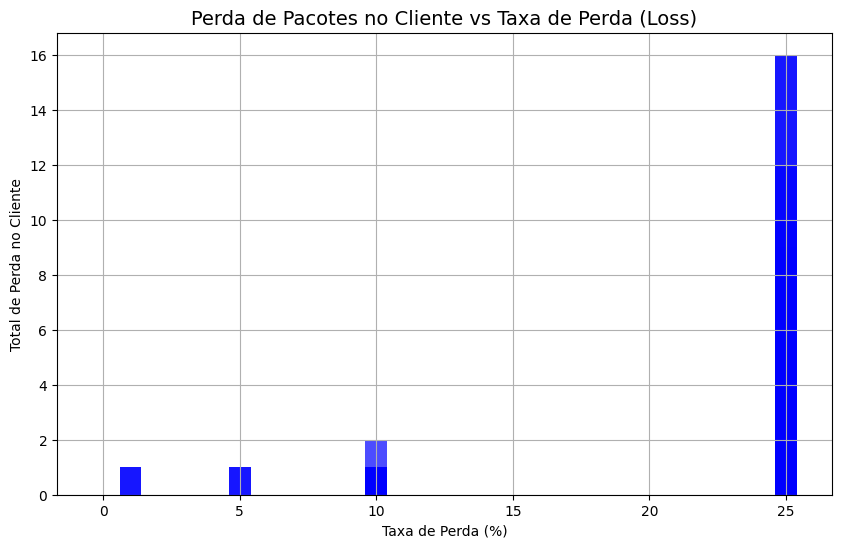

In [ ]:
# Gráfico de Barras - Total de Perda de Pacotes no Cliente
plt.figure(figsize=(10,6))
plt.bar(df['Loss'], df['Total_loss_client_emqx'], color='blue', alpha=0.7)
plt.title('Perda de Pacotes no Cliente vs Taxa de Perda (Loss)', fontsize=14)
plt.xlabel('Taxa de Perda (%)')
plt.ylabel('Total de Perda no Cliente')
plt.grid(True)
plt.show()


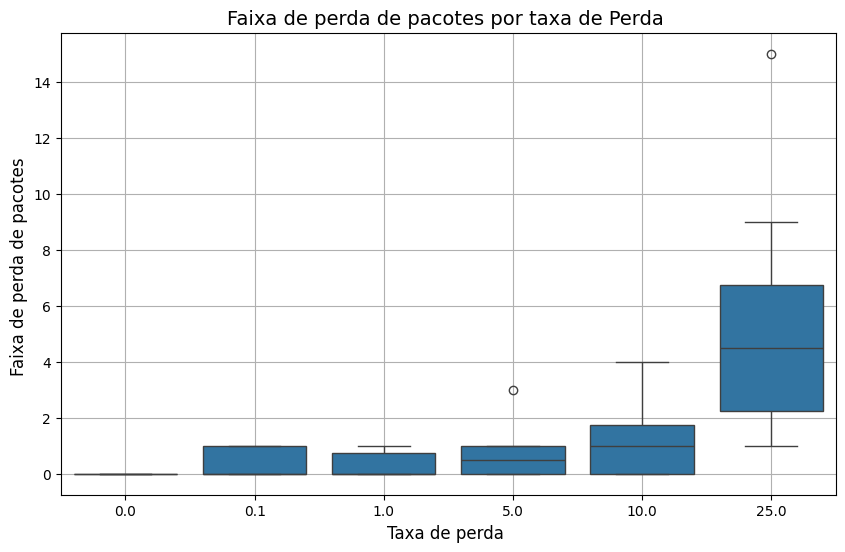

In [ ]:
df['Max_Loss'] = df[['Total_loss_client_emqx', 'Total_loss_emqx_client']].max(axis=1)
df['Min_Loss'] = df[['Total_loss_client_emqx', 'Total_loss_emqx_client']].min(axis=1)

df['Loss_Range'] = df['Max_Loss'] - df['Min_Loss']

box_data = pd.melt(df, id_vars=['Loss'], value_vars=['Loss_Range'],
                   var_name='Tipo de Perda', value_name='Faixa de Perda')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Loss', y='Faixa de Perda', data=box_data)

plt.title('Faixa de perda de pacotes por taxa de Perda ', fontsize=14)
plt.xlabel('Taxa de perda ', fontsize=12)
plt.ylabel('Faixa de perda de pacotes ', fontsize=12)

plt.grid(True)

# Exibindo o gráfico
plt.show()

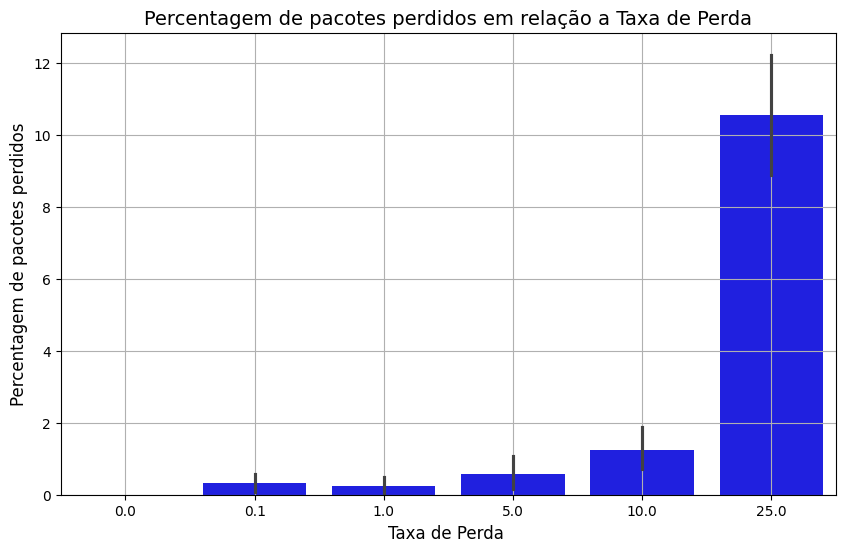

In [ ]:
df['Pacotes_Perdidos_Percent'] = (
    (df['Total_loss_emqx_client'] + df['Total_loss_client_emqx']) / df['Total_Packets']) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='Loss', y='Pacotes_Perdidos_Percent', data=df, color='b')

plt.title('Percentagem de pacotes perdidos em relação a Taxa de Perda', fontsize=14)
plt.xlabel('Taxa de Perda ', fontsize=12)
plt.ylabel('Percentagem de pacotes perdidos', fontsize=12)

plt.grid(True)
plt.show()

In [ ]:
# Leitura do CSV
df = pd.read_csv('quic_analysis.csv')

# Ajusta a coluna 'Loss'
#df['Loss'] = df['Loss'].str.replace('%', '').astype(float)

# Adiciona coluna 'transport'
df['transport'] = 'QUIC'

# Agrupa por 'Loss'
grouped = df.groupby(['transport', 'Loss']).agg({
    'Total_Packets': ['mean', 'std'],
    'Total_Packets_Client': ['mean', 'std'],
    'Total_Packets_EMQX': ['mean', 'std'],
    'Total_send_success_client_to_emqx': ['mean', 'std'],
    'Total_send_success_emqx_to_client': ['mean', 'std'],
    'Total_loss_client_emqx': ['mean', 'std'],
    'Total_loss_emqx_client': ['mean', 'std'],
    'Total_bytes_emqx': ['mean', 'std'],
    'Total_bytes_client': ['mean', 'std'],
})

# Formata os dados
formatted_rows = []
for (transport, loss), data in grouped.iterrows():
    formatted_rows.append({
        'Transporte': transport,
        'Perda de Pacotes (%)': loss,
        'Total Packets': f"{data[('Total_Packets', 'mean')]:.2f} ± {data[('Total_Packets', 'std')]:.2f}",
        'Client Packets': f"{data[('Total_Packets_Client', 'mean')]:.2f} ± {data[('Total_Packets_Client', 'std')]:.2f}",
        'EMQX Packets': f"{data[('Total_Packets_EMQX', 'mean')]:.2f} ± {data[('Total_Packets_EMQX', 'std')]:.2f}",
       # 'Client→EMQX Success': f"{data[('Total_send_success_client_to_emqx', 'mean')]:.2f} ± {data[('Total_send_success_client_to_emqx', 'std')]:.2f}",
       # 'EMQX→Client Success': f"{data[('Total_send_success_emqx_to_client', 'mean')]:.2f} ± {data[('Total_send_success_emqx_to_client', 'std')]:.2f}",
        'Loss Client→EMQX': f"{data[('Total_loss_client_emqx', 'mean')]:.2f} ± {data[('Total_loss_client_emqx', 'std')]:.2f}",
        'Loss EMQX→Client': f"{data[('Total_loss_emqx_client', 'mean')]:.2f} ± {data[('Total_loss_emqx_client', 'std')]:.2f}",
        'Bytes EMQX': f"{data[('Total_bytes_emqx', 'mean')]:.2f} ± {data[('Total_bytes_emqx', 'std')]:.2f}",
        'Bytes Client': f"{data[('Total_bytes_client', 'mean')]:.2f} ± {data[('Total_bytes_client', 'std')]:.2f}"
    })

formatted_table = pd.DataFrame(formatted_rows)
formatted_table = formatted_table.sort_values(by=['Perda de Pacotes (%)']).reset_index(drop=True)


def save_summary_table(df, filename='tabela_quic_summary.png'):
    n_rows, n_cols = df.shape
    fig_height = n_rows * 0.6 + 2
    fig, ax = plt.subplots(figsize=(20, fig_height))
    ax.axis('off')

    row_colors = ['#f9f9f9' if i % 2 == 0 else 'white' for i in range(n_rows)]

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(1)
        if row == 0:
            cell.set_text_props(weight='bold', verticalalignment='center', color='black')
            cell.set_facecolor('#d0d0d0')
            cell.PAD = 0.3
        elif row > 0:
            cell.set_facecolor(row_colors[row - 1])
            if col == 0:
                cell.set_text_props(weight='bold')

    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    plt.savefig(filename, dpi=300, bbox_inches='tight')

# Salvar a imagem com o resumo por perda
save_summary_table(formatted_table)


KeyError: 'Loss'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('quic_analysis.csv')
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')  

# Limpa coluna Loss e cria coluna transport
df['Loss'] = df['Loss'].str.strip().str.replace('%', '').astype(float)
df['transport'] = 'QUIC'

def save_summary_table(df, filename='tabela_quic_summary.png'):
    n_rows, n_cols = df.shape
    fig_height = n_rows * 0.6 + 2
    fig, ax = plt.subplots(figsize=(20, fig_height))
    ax.axis('off')

    row_colors = ['#f9f9f9' if i % 2 == 0 else 'white' for i in range(n_rows)]

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(1)
        if row == 0:
            cell.set_text_props(weight='bold', verticalalignment='center', color='black')
            cell.set_facecolor('#d0d0d0')
            cell.PAD = 0.3
        elif row > 0:
            cell.set_facecolor(row_colors[row - 1])
            if col == 0:
                cell.set_text_props(weight='bold')

    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Loop para cada valor de QoS
for qos_level in sorted(df['QoS'].unique()):
    df_qos = df[df['QoS'] == qos_level]

    grouped = df_qos.groupby(['transport', 'Loss']).agg({
        'Total_Packets': ['mean', 'std'],
        'Total_Packets_Client': ['mean', 'std'],
        'Total_Packets_EMQX': ['mean', 'std'],
        'Total_send_success_client_to_emqx': ['mean', 'std'],
        'Total_send_success_emqx_to_client': ['mean', 'std'],
        'Total_loss_client_emqx': ['mean', 'std'],
        'Total_loss_emqx_client': ['mean', 'std'],
        'Total_bytes_emqx': ['mean', 'std'],
        'Total_bytes_client': ['mean', 'std'],
    })

    formatted_rows = []
    for (transport, loss), data in grouped.iterrows():
        formatted_rows.append({
            #'Transporte': transport,
            'Perda de Pacotes (%)': loss,
            'Total Packets': f"{data[('Total_Packets', 'mean')]:.2f} ± {data[('Total_Packets', 'std')]:.2f}",
            'Client Packets': f"{data[('Total_Packets_Client', 'mean')]:.2f} ± {data[('Total_Packets_Client', 'std')]:.2f}",
            'EMQX Packets': f"{data[('Total_Packets_EMQX', 'mean')]:.2f} ± {data[('Total_Packets_EMQX', 'std')]:.2f}",
            #'Client→EMQX Success': f"{data[('Total_send_success_client_to_emqx', 'mean')]:.2f} ± {data[('Total_send_success_client_to_emqx', 'std')]:.2f}",
            #'EMQX→Client Success': f"{data[('Total_send_success_emqx_to_client', 'mean')]:.2f} ± {data[('Total_send_success_emqx_to_client', 'std')]:.2f}",
            'Loss Client→EMQX': f"{data[('Total_loss_client_emqx', 'mean')]:.2f} ± {data[('Total_loss_client_emqx', 'std')]:.2f}",
            'Loss EMQX→Client': f"{data[('Total_loss_emqx_client', 'mean')]:.2f} ± {data[('Total_loss_emqx_client', 'std')]:.2f}",
            'Bytes EMQX': f"{data[('Total_bytes_emqx', 'mean')]:.2f} ± {data[('Total_bytes_emqx', 'std')]:.2f}",
            'Bytes Client': f"{data[('Total_bytes_client', 'mean')]:.2f} ± {data[('Total_bytes_client', 'std')]:.2f}"
        })

    formatted_table = pd.DataFrame(formatted_rows)
    formatted_table = formatted_table.sort_values(by=[ 'Perda de Pacotes (%)']).reset_index(drop=True)

    # Salva a tabela com o nome indicando o QoS
    save_summary_table(formatted_table, filename=f'tabela_quic_qos_{qos_level}.png')


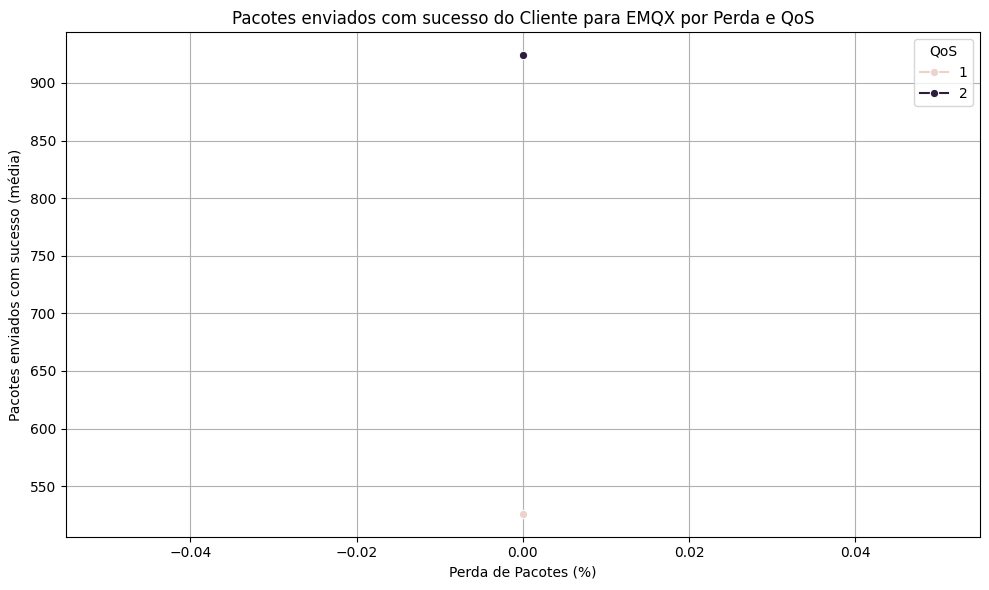

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega e prepara os dados (ajuste o caminho do csv)
df = pd.read_csv('quic_analysis_normal.csv')

# Ajusta os nomes das colunas
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Remove o símbolo % da coluna loss e converte para float
df['loss'] = df['loss'].str.replace('%', '').astype(float)

# Cria uma média por perda e qos
summary = df.groupby(['qos', 'loss']).agg({
    'total_send_success_client_to_emqx': 'mean',
    'total_send_success_emqx_to_client': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=summary, x='loss', y='total_send_success_client_to_emqx', hue='qos', marker='o')

plt.title('Pacotes enviados com sucesso do Cliente para EMQX por Perda e QoS')
plt.xlabel('Perda de Pacotes (%)')
plt.ylabel('Pacotes enviados com sucesso (média)')
plt.grid(True)
plt.legend(title='QoS')
plt.tight_layout()
plt.show()


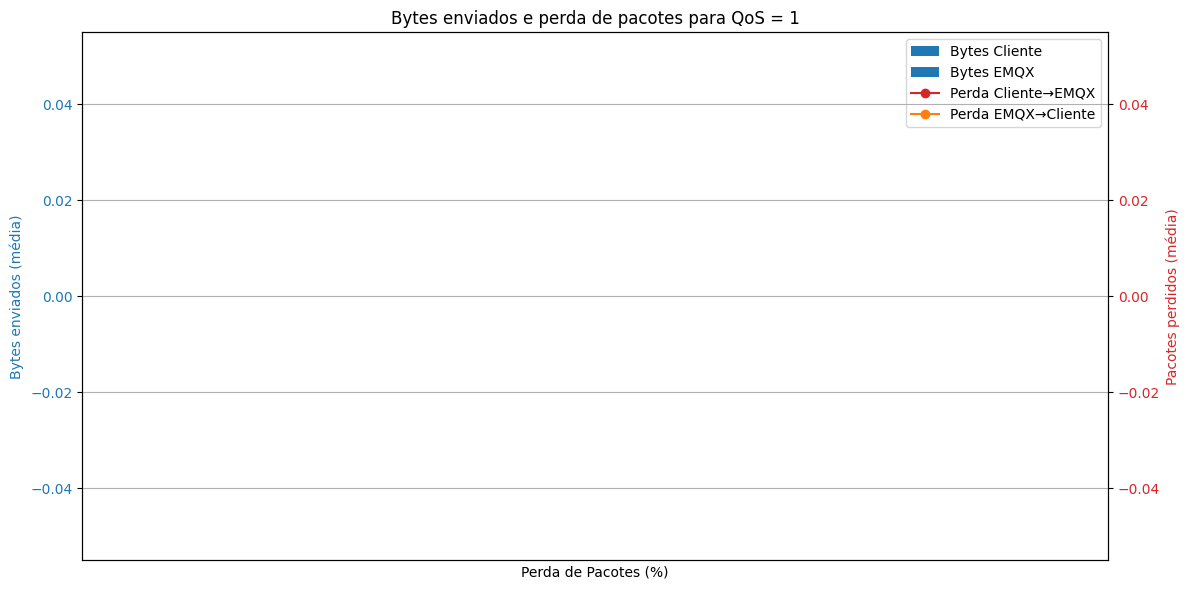

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carrega e prepara os dados
df = pd.read_csv('quic_analysis.csv')
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df['loss'] = df['loss'].str.replace('%', '').astype(float)

# Agrupamos por QoS e perda (loss) e calculamos médias
summary = df.groupby(['qos', 'loss']).agg({
    'total_bytes_client': 'mean',
    'total_bytes_emqx': 'mean',
    'total_loss_client_emqx': 'mean',
    'total_loss_emqx_client': 'mean'
}).reset_index()

# Vamos fazer um gráfico para um QoS específico (exemplo: QoS=1)
qos_level = 1
df_plot = summary[summary['qos'] == qos_level]

x = np.arange(len(df_plot['loss']))  # posições no eixo X

width = 0.2  # largura das barras

fig, ax1 = plt.subplots(figsize=(12,6))

# Barras dos bytes enviados
bars_client = ax1.bar(x - width/2, df_plot['total_bytes_client'], width, label='Bytes Cliente', color='tab:blue')
bars_emqx = ax1.bar(x + width/2, df_plot['total_bytes_emqx'], width, label='Bytes EMQX', color='tab:cyan')

ax1.set_xlabel('Perda de Pacotes (%)')
ax1.set_ylabel('Bytes enviados (média)', color='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot['loss'].astype(str))
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Segundo eixo y para perdas
ax2 = ax1.twinx()
line_client_loss = ax2.plot(x, df_plot['total_loss_client_emqx'], label='Perda Cliente→EMQX', color='tab:red', marker='o')
line_emqx_loss = ax2.plot(x, df_plot['total_loss_emqx_client'], label='Perda EMQX→Cliente', color='tab:orange', marker='o')

ax2.set_ylabel('Pacotes perdidos (média)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Legenda combinada
lines = [bars_client, bars_emqx] + line_client_loss + line_emqx_loss
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title(f'Bytes enviados e perda de pacotes para QoS = {qos_level}')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
